<a href="https://colab.research.google.com/github/NahuelCostaCortez/InteligeciaNegocio/blob/main/SequentialVsFunctional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Layer
from tensorflow.keras.utils import plot_model

En Tensorflow existen dos maneras de programar redes neuronales:



*   Sequential API
*   Functional API


**Sequential API**


> ✅ Permite crear modelos capa por capa para la mayoría de problemas.


> ❌ Está limitada porque no permite crear modelos que compartan capas o tengan múltiples entradas o salidas.


**Funtional API**



> ✅ Permite crear modelos mucho más flexibles. Se pueden conectar capas a cualquier otra capa u operación. Como resultado, es posible crear redes más complejas.



> ❌ La simplicidad del código se ve afectada.


## Ejemplo

Queremos implementar una red recurrente para procesar datos secuenciales. La red tendrá la siguiente estructura:



*   Capa de entrada
*   Capa LSTM
*   Capa Dense


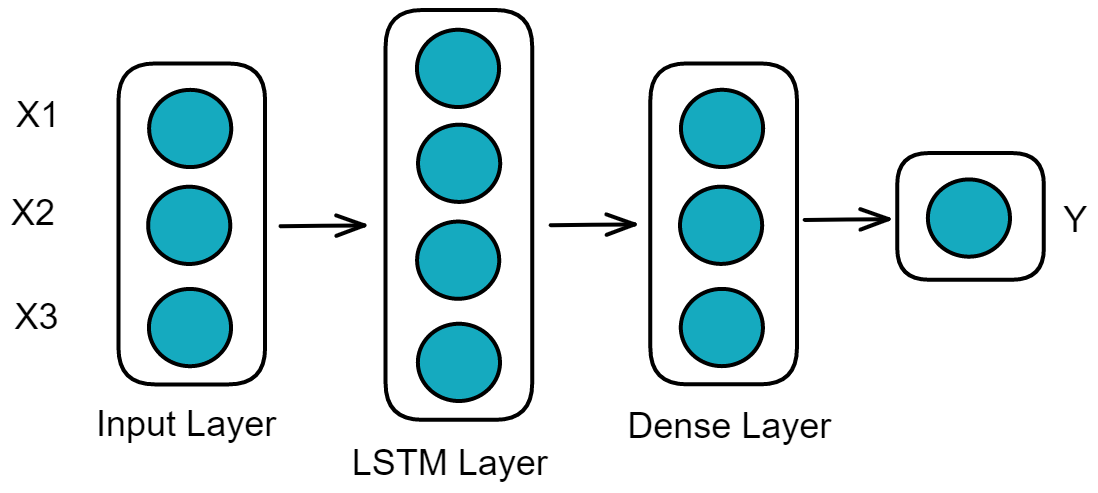



In [2]:
# Si los datos a procesar son series temporales
time_steps = 32
num_features = 4

## Implementación con Sequential

Aquí simplemente vamos añadiendo al modelo las capas que queremos

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17664     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 19,777
Trainable params: 19,777
Non-trainable params: 0
_________________________________________________________________


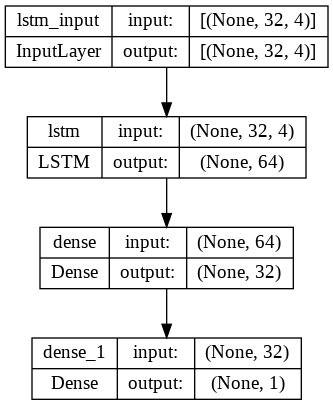

In [3]:
model = Sequential()
model.add(LSTM(64, input_shape=(time_steps,num_features)))
model.add(Dense(32))
model.add(Dense(1))
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Compilar y entrenar
# ...

## Implementación con Functional

Aquí se define cada capa de forma independiente y se especifica el input de cada una (normalmente la salida de la capa anteriormente definida)

In [4]:
input_layer = Input(shape=(time_steps,num_features))
lstm_layer = LSTM(64)(input_layer)
dense_layer = Dense(32)(lstm_layer)
y = Dense(1)(dense_layer)
model = Model(inputs=input_layer, outputs=y)
model.summary()

# Otra forma
'''
input_layer = Input(shape=(time_steps,num_features))
lstm_layer = LSTM(64)
dense_layer = Dense(32)
output_layer = Dense(1)

y = lstm_layer(input_layer)
y = dense_layer(y)
y = output_layer(y)
model = Model(inputs=input_layer, outputs=y)
model.summary()
'''

# Compilar y entrenar
# ...

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 4)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                17664     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 19,777
Trainable params: 19,777
Non-trainable params: 0
_________________________________________________________________


'\ninput_layer = Input(shape=(time_steps,num_features))\nlstm_layer = LSTM(64)\ndense_layer = Dense(32)\noutput_layer = Dense(1)\n\ny = lstm_layer(input_layer)\ny = dense_layer(y)\ny = output_layer(y)\nmodel = Model(inputs=input_layer, outputs=y)\nmodel.summary()\n'

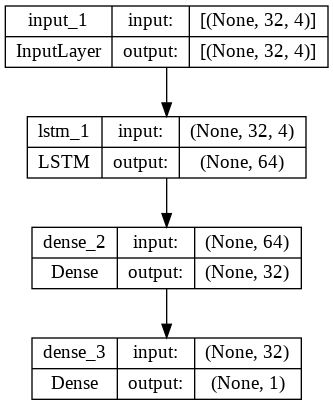

In [5]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

❗ No hay ninguna diferencia entre estas aproximaciones

Supongamos ahora que queremos añadir una rama a la red:

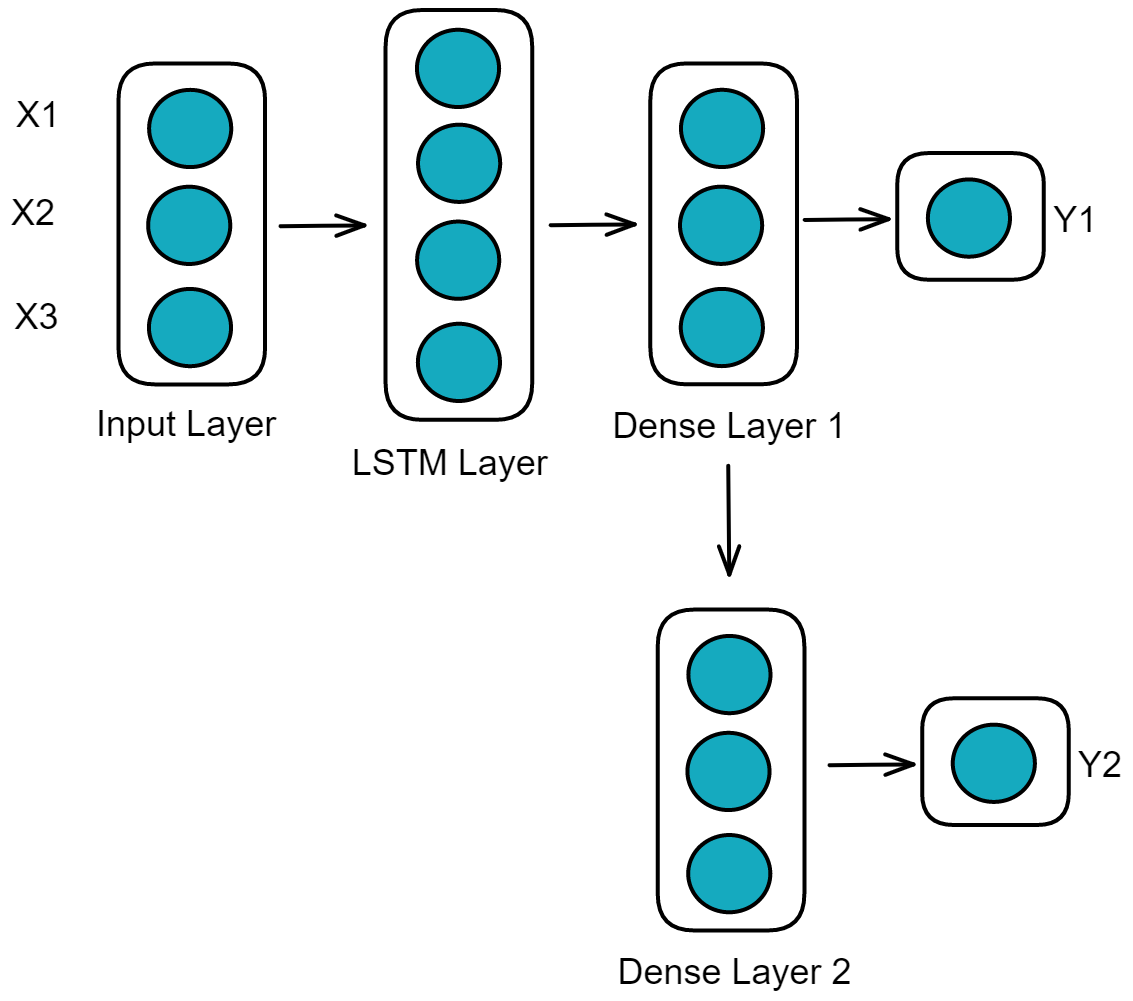

Con la API secuencial esto no se puede hacer, las capas van apiladas de forma secuencial y aquí se quiere tener dos capas en paralelo.



Sin embargo, con la API functional:

In [6]:
input_layer = Input(shape=(time_steps,num_features))
lstm_layer = LSTM(64)(input_layer)
dense_layer_1 = Dense(32)(lstm_layer)
y_1 = Dense(1)(dense_layer_1)
# ----- Nueva rama -----
dense_layer_2 = Dense(32)(dense_layer_1)
y_2 = Dense(1)(dense_layer_2)
# ----------------------
model = Model(inputs=input_layer, outputs=[y_1, y_2])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 4)]      0           []                               
                                                                                                  
 lstm_2 (LSTM)                  (None, 64)           17664       ['input_2[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 32)           2080        ['lstm_2[0][0]']                 
                                                                                                  
 dense_5 (Dense)                (None, 32)           1056        ['dense_4[0][0]']                
                                                                                            

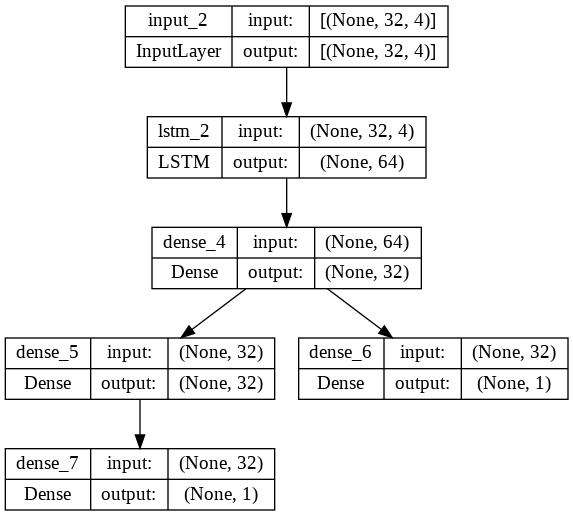

In [7]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

❓ Por qué en Functional tenemos dos pares de paréntesis?

Cada capa está definida como una clase, que tiene como mínimo dos métodos:



*   Método init: para inicializar los parámetros de la clase
*   Método call: para definir las operaciones que se realizan con los datos de entrada


Para usarla, primero hay que instanciarla (llamada a **init** -> primer paréntesis) y luego cuando se llama se computa el método "**call**" -> segundo paréntesis

In [8]:
class DenseSimplified(Layer):
  def __init__(self, units):
    """
    units: número de neuronas de la capa
    """
    super().__init__()

    self.units = units

  def call(self, inputs):
    """
    x: datos
    """
    outputs = tf.matmul(a=inputs, b=self.units*tf.constant([1, 1, 1, 1, 1, 1], shape=(inputs.shape[1], inputs.shape[0]))) # ESTA OPERACIÓN ES INVENTADA

    return outputs

In [9]:
input_data = tf.constant([1, 2, 3, 4, 5, 6], shape=[2, 3]) # Datos inventados
dense_layer = DenseSimplified(32) # Llamada a init
output = dense_layer(input_data) # Llamada a call
output

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[192, 192],
       [480, 480]], dtype=int32)>